In [1]:
import pathlib

import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.spatial
import seaborn as sns
from IPython.display import HTML

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport src.visualization.clouds

In [4]:
data_dir = pathlib.Path("../../data").resolve()

data_paths = {
    "lysva-raw": data_dir / "raw" / "lysva",
    "lysva-interim": data_dir / "interim" / "lysva",
    "trees": data_dir / "raw" / "trees",
}

In [5]:
lysva_field_survey = gpd.read_file(data_paths["lysva-raw"] / "field_survey.geojson")
lysva_als_files = sorted((data_paths["lysva-interim"] / "als").glob("*.las"))
lysva_ortho_files = sorted((data_paths["lysva-raw"] / "ortho").glob("*.tif"))

In [6]:
#| include: true
#| label: tbl-inventory-example
#| tbl-cap: Example of data in the field inventory table. Each row is a recorded tree.

display(HTML(lysva_field_survey.sample(5, random_state=1917).to_html(index=False)))

plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
7.0,111.0,Birch,23.0,23.0,23.00,NaN,NaN,0.0,None,POINT (545784.419 6449359.132)
5.0,136.0,Fir,23.5,23.0,23.25,90.0,17.5,0.0,Rotten,POINT (545721.242 6449901.051)
3.0,119.0,Aspen,36.1,42.1,39.10,89.0,25.5,0.0,None,POINT (546630.326 6450158.241)
9.0,345.0,Spruce,19.7,22.0,20.85,NaN,15.9,0.0,None,POINT (546201.645 6449118.199)
6.0,267.0,Spruce,12.9,12.9,12.90,NaN,NaN,0.0,None,POINT (545568.842 6449407.13)


In [7]:
def get_point_density(plot):
    file = data_paths["lysva-interim"] / "als" / f"plot_{plot:02.0f}.las"
    points = np.unique(laspy.read(file).xyz, axis=0)
    hull = scipy.spatial.ConvexHull(points[:, :2])
    return points.shape[0] / hull.volume


def get_plot_stats(plot):
    subset = lysva_field_survey.query(f"plot == {plot}")
    return {"dominant_type": subset["Type"].mode()[0]}


conifiers = {"Spruce", "Fir", "Pine"}

lysva_field_survey["Type"] = lysva_field_survey["species"].map(
    lambda x: "Coniferous" if x in conifiers else "Deciduous"
)

plot_stats = lysva_field_survey.groupby("plot", as_index=False).size()
plot_stats["Point density"] = round(plot_stats["plot"].map(get_point_density), 1)
plot_stats[["Dominant type"]] = pd.json_normalize(
    plot_stats["plot"].map(get_plot_stats)
)
plot_stats = plot_stats.rename(columns={"plot": "Plot", "size": "Tree count"})

In [8]:
#| include: true
#| label: tbl-lysva-plot-stats
#| tbl-cap: Statistics for the plots in the Lysva dataset.

display(HTML(plot_stats.to_html(index=False)))

Plot,Tree count,Point density,Dominant type
1.0,420,31.7,Deciduous
2.0,365,47.9,Deciduous
3.0,332,40.3,Deciduous
4.0,261,33.5,Coniferous
5.0,208,14.2,Coniferous
6.0,290,39.1,Coniferous
7.0,408,41.9,Deciduous
8.0,341,35.5,Coniferous
9.0,459,42.1,Coniferous
10.0,518,42.9,Deciduous


In [9]:
las = laspy.read(lysva_als_files[9])
xyz = las.xyz
color = np.stack([las.red, las.green, las.blue], axis=1)

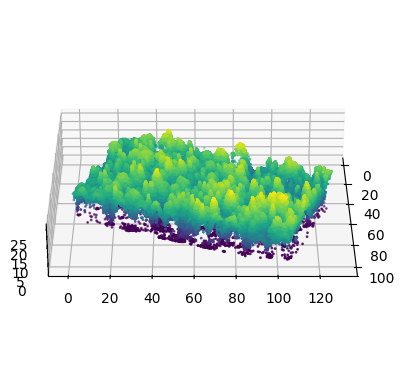

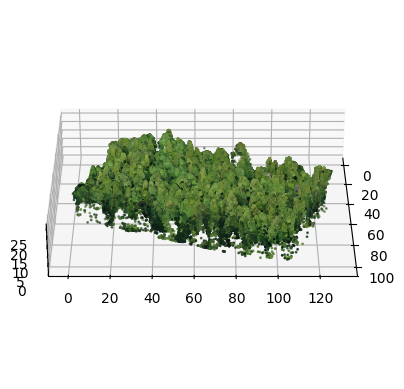

In [10]:
#| include: true
#| label: fig-example-3d-point-cloud
#| layout-ncol: 2
#| fig-cap: A 3D visualization of the UAV LiDAR point cloud of plot 10.
#| fig-subcap:
#|   - Points colored by height.
#|   - Points assigned color by sampling the orthophoto.

params = {
    "azim": 0,
}

ax = src.visualization.clouds.scatter_point_cloud_3d(xyz, **params)
src.visualization.clouds.scatter_point_cloud_3d(xyz, color=color / 255, **params);

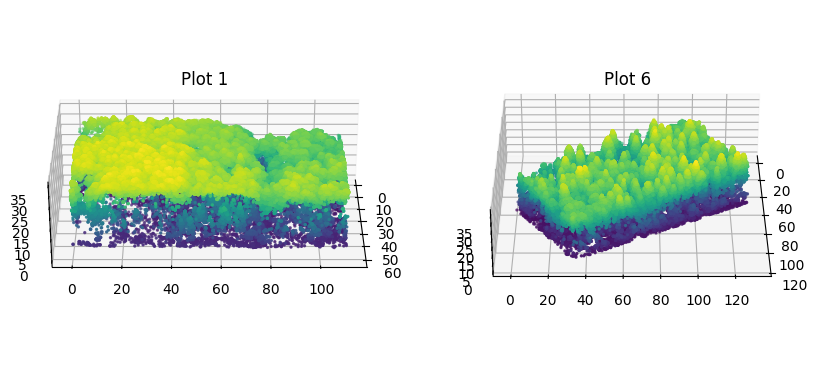

In [11]:
#| include: true
#| label: fig-lysva-canopy-structure
#| fig-cap: |
#|  3D visualizations of point clouds from plot 1 (predominantly deciduous) and
#|  plot 6 (predominantly coniferous). Note the difference in the canopy structure:
#|  it is relatively easy to tell confifiers apart visually, while deciduous species
#|  do not have pronounced shapes and are hard to discriminate.
#|  Figure reused from @dubrovinOpenDatasetIndividual2024.


plot1 = laspy.read("../../data/raw/lysva/als/plot_01.las").xyz
plot6 = laspy.read("../../data/raw/lysva/als/plot_06.las").xyz

for cloud in (plot1, plot6):
    cloud -= cloud.min(axis=0, keepdims=True)

fig = plt.figure(figsize=(10, 5))
ax0 = fig.add_subplot(1, 2, 1, projection="3d")
ax1 = fig.add_subplot(1, 2, 2, projection="3d")

ax0.scatter(
    *plot1.swapaxes(0, 1),
    c=plot1[:, 2],
    s=2,
)

ax1.scatter(
    *plot6.swapaxes(0, 1),
    c=plot6[:, 2],
    s=2,
)

ax0.view_init(elev=30, azim=0)
ax1.view_init(elev=30, azim=0)

ax0.set_title("Plot 1", y=0.83)
ax1.set_title("Plot 6", y=0.83)

for ax in (ax0, ax1):
    ax.set_aspect("equal")

In [12]:
with rasterio.open(lysva_ortho_files[9]) as dd:
    ortho = dd.read()

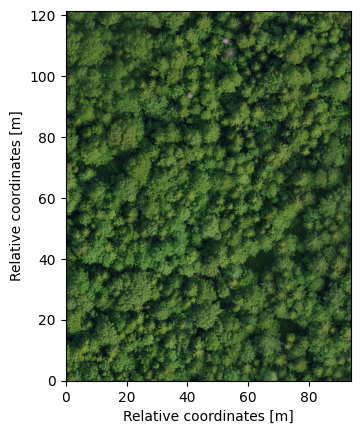

In [13]:
#| include: true
#| label: fig-example-ortho
#| fig-cap: A visualization of the orthophoto of plot 10.

fig, ax = plt.subplots()
ax.imshow(
    X=np.rollaxis(ortho, 0, 3),
    extent=[0, dd.bounds.right - dd.bounds.left, 0, dd.bounds.top - dd.bounds.bottom],
)
ax.set_xlabel("Relative coordinates [m]")
ax.set_ylabel("Relative coordinates [m]");

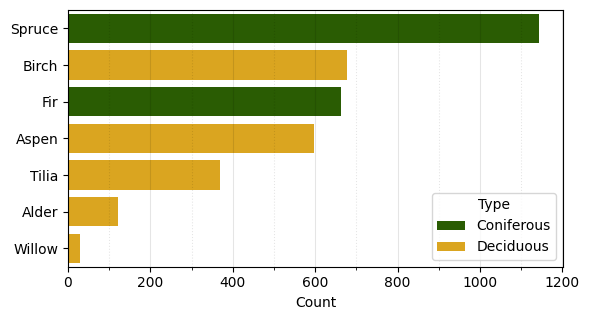

In [14]:
#| include: true
#| label: fig-lysva-species-distribution
#| fig-cap: |
#|  Distribution of species in the Lysva field inventory dataset. The dominant species
#|  is spruce, but overall the split between coniferous and decidious species is even:
#|  there are 1807 coniferous and 1793 deciduous trees.
#|  Figure reused from @dubrovinOpenDatasetIndividual2024.

counts = (
    lysva_field_survey.query("species not in ['Elm', 'Pine']")
    .value_counts("species")
    .reset_index()
)
counts["Type"] = counts["species"].map(
    lambda x: "Coniferous" if x in conifiers else "Deciduous"
)

fig, ax = plt.subplots(figsize=(6, 3.3), tight_layout=True)
ax = sns.barplot(
    data=counts,
    x="count",
    y="species",
    hue="Type",
    dodge=False,
    hue_order=["Coniferous", "Deciduous"],
    palette=["#2A5C03", "#DAA520"],
    saturation=1,
    ax=ax,
)
ax.set_xlabel("Count")
ax.set_ylabel(None)
ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
ax.grid(axis="x", color="black", alpha=0.1)
ax.grid(which="minor", axis="x", color="black", alpha=0.1, ls=":")

In [15]:
lysva_field_survey.query("species not in ['Elm', 'Pine']").groupby("Type").size()

Type
Coniferous    1807
Deciduous     1793
dtype: int64

In [16]:
full_intensity = np.concatenate([laspy.read(x).intensity for x in lysva_als_files])
full_intensity.size, full_intensity.min(), full_intensity.max()

(2739182, np.uint16(2), np.uint16(63))

In [17]:
2**6 - 1

63

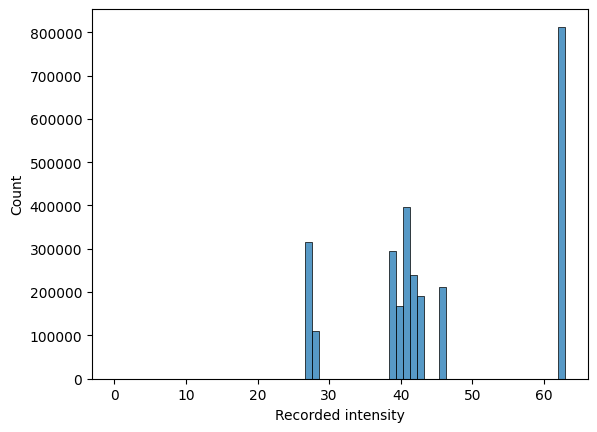

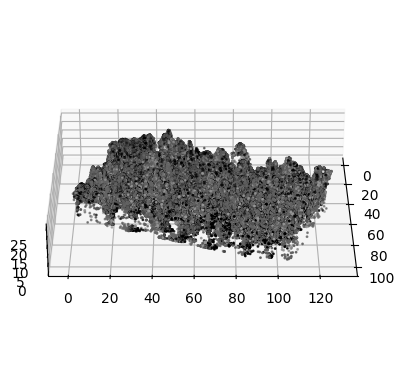

In [18]:
#| include: true
#| label: fig-intensity-with-example
#| layout-ncol: 2
#| fig-cap: An example of the unreliability of the intensity attribute.
#| fig-subcap:
#|   - Distribution of intensity over all points in the Lysva dataset.
#|   - A point cloud of plot 10 with points colored by intensity.

ax = sns.histplot(full_intensity, binrange=(0, 63), bins=64)
ax.set_xlabel("Recorded intensity")
src.visualization.clouds.scatter_point_cloud_3d(
    xyz,
    color=las.intensity,
    **params,
    cmap="binary",
);